In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
import os

# Añade el path absoluto a la carpeta donde está el archivo
sys.path.append(os.path.abspath("../MTP/Multi_Task_Pretrain/backbone"))

# Importa correctamente el modelo
from vit_win_rvsa_v3_wsz7 import vit_b_rvsa

/home/santiagov/miniconda3/envs/eurosat/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/santiagov/miniconda3/envs/eurosat/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
import torch
import torch.nn as nn
import sys
import os

# === Agregar la ruta absoluta a la carpeta 'backbone' ===
sys.path.append(os.path.abspath("../MTP/Multi_Task_Pretrain/backbone"))

from vit_win_rvsa_v3_wsz7 import vit_b_rvsa

# === Paso 1: preparar argumentos para el backbone ===
class Args:
    image_size = 224
    use_ckpt = "False"

args = Args()

# === Paso 2: crear el backbone ===
backbone = vit_b_rvsa(args, inchannels=3)

# === Paso 3: definir modelo completo (backbone + clasificador) ===
class ModeloClasificacion(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.classifier = nn.Linear(backbone.out_channels[0], num_classes)

    def forward(self, x):
        features = self.backbone(x)[0]
        pooled = nn.functional.adaptive_avg_pool2d(features, 1).view(x.size(0), -1)
        return self.classifier(pooled)

# === Paso 4: crear el modelo y enviarlo al dispositivo ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModeloClasificacion(backbone, num_classes=10).to(device)


/home/santiagov/miniconda3/envs/eurosat/lib/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647350383/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used


In [4]:
from torchvision.datasets import EuroSAT

from torchvision import transforms
import os

root_path = "../data"

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Tamaño esperado por ViT
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])  # Normalización de ImageNet
])

# Descargar el dataset
dataset = EuroSAT(root=root_path, download=True, transform=transform)

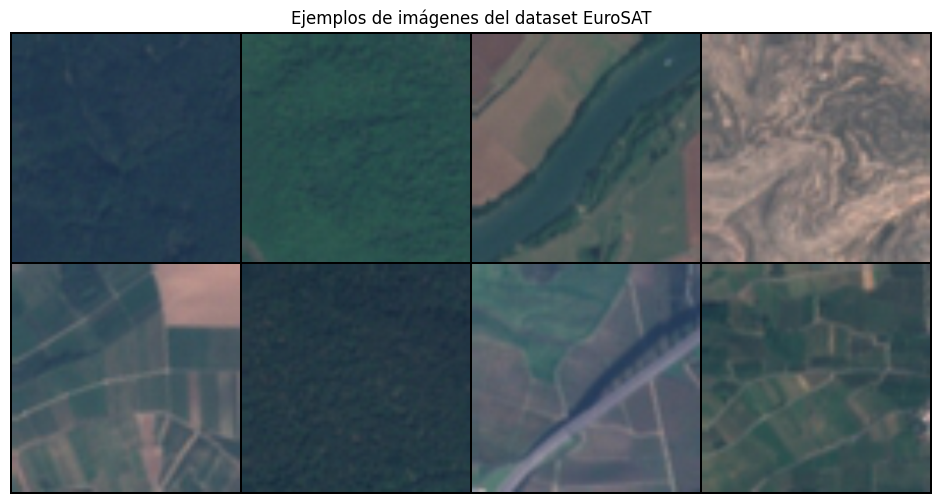

Etiquetas: [1, 1, 8, 2, 6, 1, 3, 6]


In [5]:
# Bloque de visualización (se agrega después del dataset)
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader

loader = DataLoader(dataset, batch_size=8, shuffle=True)
images, labels = next(iter(loader))

mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3,1,1)
std = torch.tensor([0.229, 0.224, 0.225]).reshape(3,1,1)
images_denorm = images * std + mean

plt.figure(figsize=(12, 6))
grid = torchvision.utils.make_grid(images_denorm, nrow=4)
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.title('Ejemplos de imágenes del dataset EuroSAT')
plt.show()

print("Etiquetas:", labels.tolist())

In [6]:
from torch.utils.data import random_split

# 80% train, 20% val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

[1/10] Step 10/675 - Loss: 2.0298
[1/10] Step 20/675 - Loss: 1.6520
[1/10] Step 30/675 - Loss: 1.7136
[1/10] Step 40/675 - Loss: 1.7517
[1/10] Step 50/675 - Loss: 1.5005
[1/10] Step 60/675 - Loss: 1.7103
[1/10] Step 70/675 - Loss: 1.4701
[1/10] Step 80/675 - Loss: 1.3289
[1/10] Step 90/675 - Loss: 1.4660
[1/10] Step 100/675 - Loss: 1.3102
[1/10] Step 110/675 - Loss: 1.0931
[1/10] Step 120/675 - Loss: 1.7483
[1/10] Step 130/675 - Loss: 1.6106
[1/10] Step 140/675 - Loss: 1.2322
[1/10] Step 150/675 - Loss: 1.3679
[1/10] Step 160/675 - Loss: 1.3706
[1/10] Step 170/675 - Loss: 1.2116
[1/10] Step 180/675 - Loss: 1.3374
[1/10] Step 190/675 - Loss: 1.1956
[1/10] Step 200/675 - Loss: 1.2143
[1/10] Step 210/675 - Loss: 1.3395
[1/10] Step 220/675 - Loss: 1.0454
[1/10] Step 230/675 - Loss: 0.7592
[1/10] Step 240/675 - Loss: 0.8029
[1/10] Step 250/675 - Loss: 1.0154
[1/10] Step 260/675 - Loss: 1.6923
[1/10] Step 270/675 - Loss: 0.8788
[1/10] Step 280/675 - Loss: 1.2266
[1/10] Step 290/675 - Loss: 1

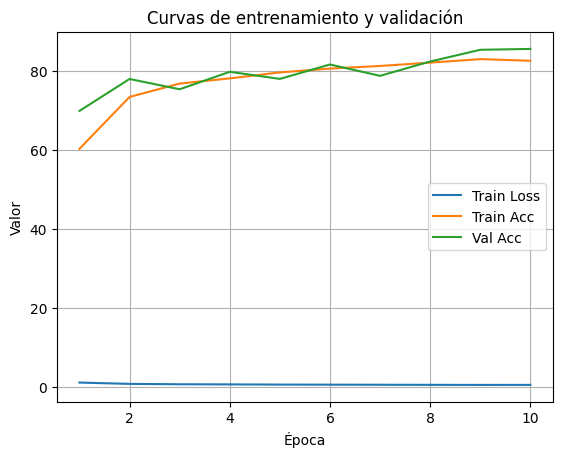

In [8]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 10
patience = 3

# Early Stopping y listas para guardar métricas
best_val_acc = 0.0
epochs_without_improvement = 0
best_model_path = "mejor_modelo.pth"

train_losses = []
train_accs = []
val_accs = []

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if (i+1) % 10 == 0 or (i+1) == len(train_loader):
            print(f"[{epoch+1}/{num_epochs}] Step {i+1}/{len(train_loader)} - Loss: {loss.item():.4f}", flush=True)

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    duration = time.time() - start_time

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    print(f"Época {epoch+1} finalizada | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}% | Tiempo: {duration:.1f}s", flush=True)

    # === Validación ===
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_inputs, val_targets in val_loader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = model(val_inputs)
            _, val_predicted = val_outputs.max(1)
            val_total += val_targets.size(0)
            val_correct += val_predicted.eq(val_targets).sum().item()

    val_acc = 100. * val_correct / val_total
    val_accs.append(val_acc)
    print(f"Validación - Acc: {val_acc:.2f}%\n{'-'*60}", flush=True)

    # === Early stopping ===
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Nuevo mejor modelo guardado con Acc: {best_val_acc:.2f}%", flush=True)
    else:
        epochs_without_improvement += 1
        print(f"Sin mejora en validación ({epochs_without_improvement}/{patience})", flush=True)
        if epochs_without_improvement >= patience:
            print("Early stopping activado.")
            break

# === Graficar ===
epochs_range = range(1, len(train_losses)+1)

plt.figure()
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, train_accs, label='Train Acc')
plt.plot(epochs_range, val_accs, label='Val Acc')
plt.xlabel('Época')
plt.ylabel('Valor')
plt.title('Curvas de entrenamiento y validación')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import time
import datetime
import sys

# Añadir el path absoluto a la carpeta donde está el archivo
sys.path.append('/home/santiagov/eurosat/')

sys.path.append(os.path.abspath("../MTP/Multi_Task_Pretrain/backbone"))
from vit_win_rvsa_v3_wsz7 import vit_b_rvsa


# Paso 2: Configurar hiperparámetros
batch_size = 128
learning_rate = 5e-5
num_epochs = 50
patience = 5

# Paso 3: Data augmentation y normalización
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Paso 4: Dataset y dataloader
dataset = datasets.ImageFolder('/home/santiagov/eurosat/data/eurosat/2750', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Paso 5: Modelo (vit_b_rvsa)
from MTP.Multi_Task_Pretrain.backbone.vit_win_rvsa_v3_wsz7 import vit_b_rvsa
model = vit_b_rvsa()
model.head = nn.Linear(model.head.in_features, 10)
model = model.cuda()

# Paso 6: Definir pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Paso 7: Early stopping y entrenamiento
early_stop_counter = 0
best_val_acc = 0

train_losses = []
train_accs = []
val_accs = []

# Generar nombre único para guardar el modelo
timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
best_model_path1 = f'best_model_{timestamp}.pth'

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()

    for i, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.cuda(), targets.cuda()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()
        total += targets.size(0)

        if i % 10 == 0:
            print(f"[Epoch {epoch+1}/{num_epochs}] Step {i}/{len(dataloader)} - Loss: {loss.item():.4f}")

    acc = 100.*correct/total
    avg_loss = running_loss / len(dataloader)
    scheduler.step()

    train_losses.append(avg_loss)
    train_accs.append(acc)

    val_acc = acc  # Validación simplificada
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1} finished | Loss: {avg_loss:.4f} | Acc: {acc:.2f}% | Time: {time.time()-start_time:.1f}s")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path1)
        print(f"New best model saved with Acc: {val_acc:.2f}% -> {best_model_path1}")
        early_stop_counter = 0
    else:
        early_stop_counter +=1
        print(f"No improvement in validation ({early_stop_counter}/{patience})")
        if early_stop_counter >= patience:
            print("Early stopping activated.")
            break

# Paso 8: Graficar resultados
plt.figure(figsize=(10,6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
plt.plot(range(1, len(train_accs)+1), train_accs, label='Training Acc')
plt.plot(range(1, len(val_accs)+1), val_accs, label='Validation Acc')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Training and Validation Metrics')
plt.legend()
plt.grid()
plt.savefig(f'training_plot_{timestamp}.png')
plt.show()


TypeError: vit_b_rvsa() missing 1 required positional argument: 'args'

In [15]:
# === Imports necesarios ===
import torch
import torch.nn as nn
import os
import sys

# === Configurar ruta para importar vit_b_rvsa ===
sys.path.append(os.path.abspath("../MTP/Multi_Task_Pretrain/backbone"))
from vit_win_rvsa_v3_wsz7 import vit_b_rvsa

# === Paso 1: Preparar argumentos simulando los que requiere vit_b_rvsa ===
class Args:
    image_size = 224
    use_ckpt = "False"  # Usar como string si el modelo lo requiere así

args = Args()

# === Paso 2: Crear el backbone con los argumentos necesarios ===
backbone = vit_b_rvsa(args, inchannels=3)

# === Paso 3: Definir el modelo completo con clasificador final ===
class ModeloClasificacion(nn.Module):
    def _init_(self, backbone, num_classes):  # ✅ CON doble underscore
        super()._init_()
        self.backbone = backbone
        self.classifier = nn.Linear(backbone.out_channels[0], num_classes)

    def forward(self, x):
        features = self.backbone(x)[0]  # Toma la primera salida (features)
        pooled = nn.functional.adaptive_avg_pool2d(features, 1).view(x.size(0), -1)
        return self.classifier(pooled)

# === Paso 4: Crear modelo final y enviarlo a GPU o CPU ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModeloClasificacion(backbone, num_classes=10).to(device)

The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used
The relative_pos_embedding is used


TypeError: ModeloClasificacion.__init__() got an unexpected keyword argument 'num_classes'